In [1]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
this_path = Path().resolve()
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils import tensorboard

from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import monai
import torchmetrics
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    RandAdjustContrast,
    RandBiasField,
    RandAffine,
    ScaleIntensity,
)
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

from dataset.ppmi_dataset import PPMIDataModule
from models.pl_model import Model

/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2023-02-27 11:28:45,798 - Created a temporary directory at /tmp/tmpdrwgcayk
2023-02-27 11:28:45,799 - Writing /tmp/tmpdrwgcayk/_remote_module_non_scriptable.py
/home/alejandrocu/Documents/parkinson_classification/models/medicalnet


In [2]:
# predict with the best model
exp_name = '3dresnet-da00_lrsch_focal_sgd01_rs128'
ckpt_name = 'epoch=39-val_acc=0.8177.ckpt'
exp_dir = Path(this_path / f'outputs/{exp_name}/version_0')
ckpt_path = exp_dir / 'checkpoints' / ckpt_name

with open(exp_dir.parent /'config_dump.yml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

print(cfg)

{'aug': 'Compose([])', 'dataset': {'random_state': 70, 'reshape_size': 200, 'train_batch_size': 5, 'train_num_workers': 2, 'val_batch_size': 5, 'val_num_workers': 2}, 'exp_name': '3dresnet-da00_lrsch_focal_sgd01_rs128', 'model': {'in_channels': 1, 'learning_rate': 0.01, 'loss': 'focal', 'n_classes': 2, 'net': '3dresnet', 'optimizer_class': 'sgd', 'sch_patience': 10}, 'pl_trainer': {'accelerator': 'gpu', 'devices': [0], 'log_every_n_steps': 10, 'max_epochs': 50, 'precision': 16}}


In [3]:
# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create dataset
data = PPMIDataModule(md_df=md_df_first, root_dir=root_dir, **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

# obtain the dataloader
test_dl = data.test_dataloader()
val_dl = data.val_dataloader()
train_dl = data.train_dataloader()

# create model
# model = Model(**cfg['model'])
# model.load_from_checkpoint(ckpt_path, **cfg['model'])
model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])
model.eval()

Training:   288
Validation:  96
Test:       97
loading pretrained model pretrain/resnet_10_23dataset.pth
Pretrained 3D resnet has a single input channel


Model(
  (criterion): BinaryFocalLossWithLogits()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
  (train_auroc): BinaryAUROC()
  (val_auroc): BinaryAUROC()
  (train_f1): BinaryF1Score()
  (val_f1): BinaryF1Score()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momen

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.net.to(device)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 

In [7]:
for subjects_batch in test_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 1, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]]) torch.Size([5, 2])


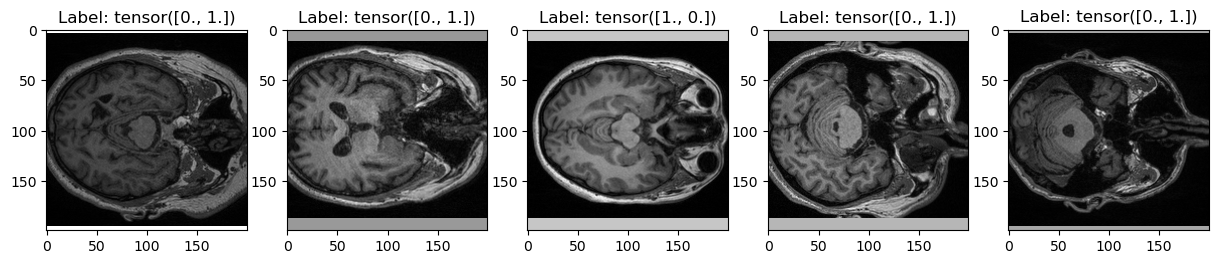

In [67]:
f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, :, :, 85], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')

In [57]:
data.md_df_test.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
974,I1583946,116008,PD,M,64,BL,MRI,SAG 3D MPRAGE,Original,2022-05-16,DCM,NaN
114,I713721,40806,PD,M,77,BL,MRI,MPRAGE w/ GRAPPA 2,Original,2016-05-10,DCM,NaN
646,I270008,3362,Control,F,42,BL,MRI,MPRAGE T1 SAG,Original,2011-05-26,DCM,NaN
485,I373034,3592,PD,M,62,BL,MRI,MPRAGE GRAPPA,Original,2013-04-15,DCM,NaN
18,I1490511,57127,PD,M,79,V10,MRI,SAG 3D MPRAGE,Original,2021-08-19,DCM,NaN


In [28]:
# pd subject, slice 105
pd_img, pd_label = inputs[4].unsqueeze(0).to(device), target[4].to(device)
print(pd_img.shape, pd_label)

torch.Size([1, 1, 200, 200, 200]) tensor([0., 1.], device='cuda:0')


In [63]:
# hc subject, slice 85
hc_img, hc_label = inputs[2].unsqueeze(0).to(device), target[2].to(device)
print(hc_img.shape, hc_label)

torch.Size([1, 1, 200, 200, 200]) tensor([1., 0.], device='cuda:0')


In [58]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model.net, mask_size=5, n_batch=10, overlap=0.25)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = 105
occ_sens_b_box = [-1, -1, -1, -1, depth_slice - 1, depth_slice]

occ_result, _ = occ_sens(x=pd_img, b_box=occ_sens_b_box)
# occ_result_s = occ_result[0, pd_label.argmax().item()][None]

100%|██████████| 436/436 [05:32<00:00,  1.31it/s]


In [53]:
occ_result_s = occ_result[0, 0][..., 0]
print(occ_result_s.shape)

torch.Size([200, 200])


In [59]:
occ_result.shape

torch.Size([1, 2, 200, 200, 1])

In [51]:
pd_img[..., depth_slice].shape

torch.Size([1, 1, 200, 200])

In [70]:
def overlay_mask_on_image(image, mask, alpha=0.5, cmap='jet'):
    """Overlay a mask on top of an image.
    Args:
        image: image to be overlaid, shape (C, H, W)
        mask: mask to be overlaid, shape (H, W)
        alpha: transparency of the mask
        cmap: colormap to use for the mask
    """
    image = image[0, ...]
    mask = mask[0, ...]
    mask = np.ma.masked_where(mask == 0, mask)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, alpha=alpha)

In [78]:
ex_mask.shape

(200, 200)

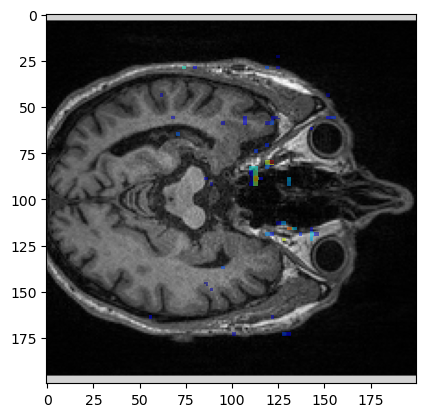

In [82]:
occ_result_s = occ_result[0, 1][..., 0]
ex_mask = occ_result_s.cpu().detach()
# ex_mask[ex_mask >= 0.8975] = 1
ex_mask[ex_mask < 0.8974] = 0
overlay_mask_on_image(pd_img[0, ..., 105].detach().cpu().numpy(), ex_mask.unsqueeze(0))



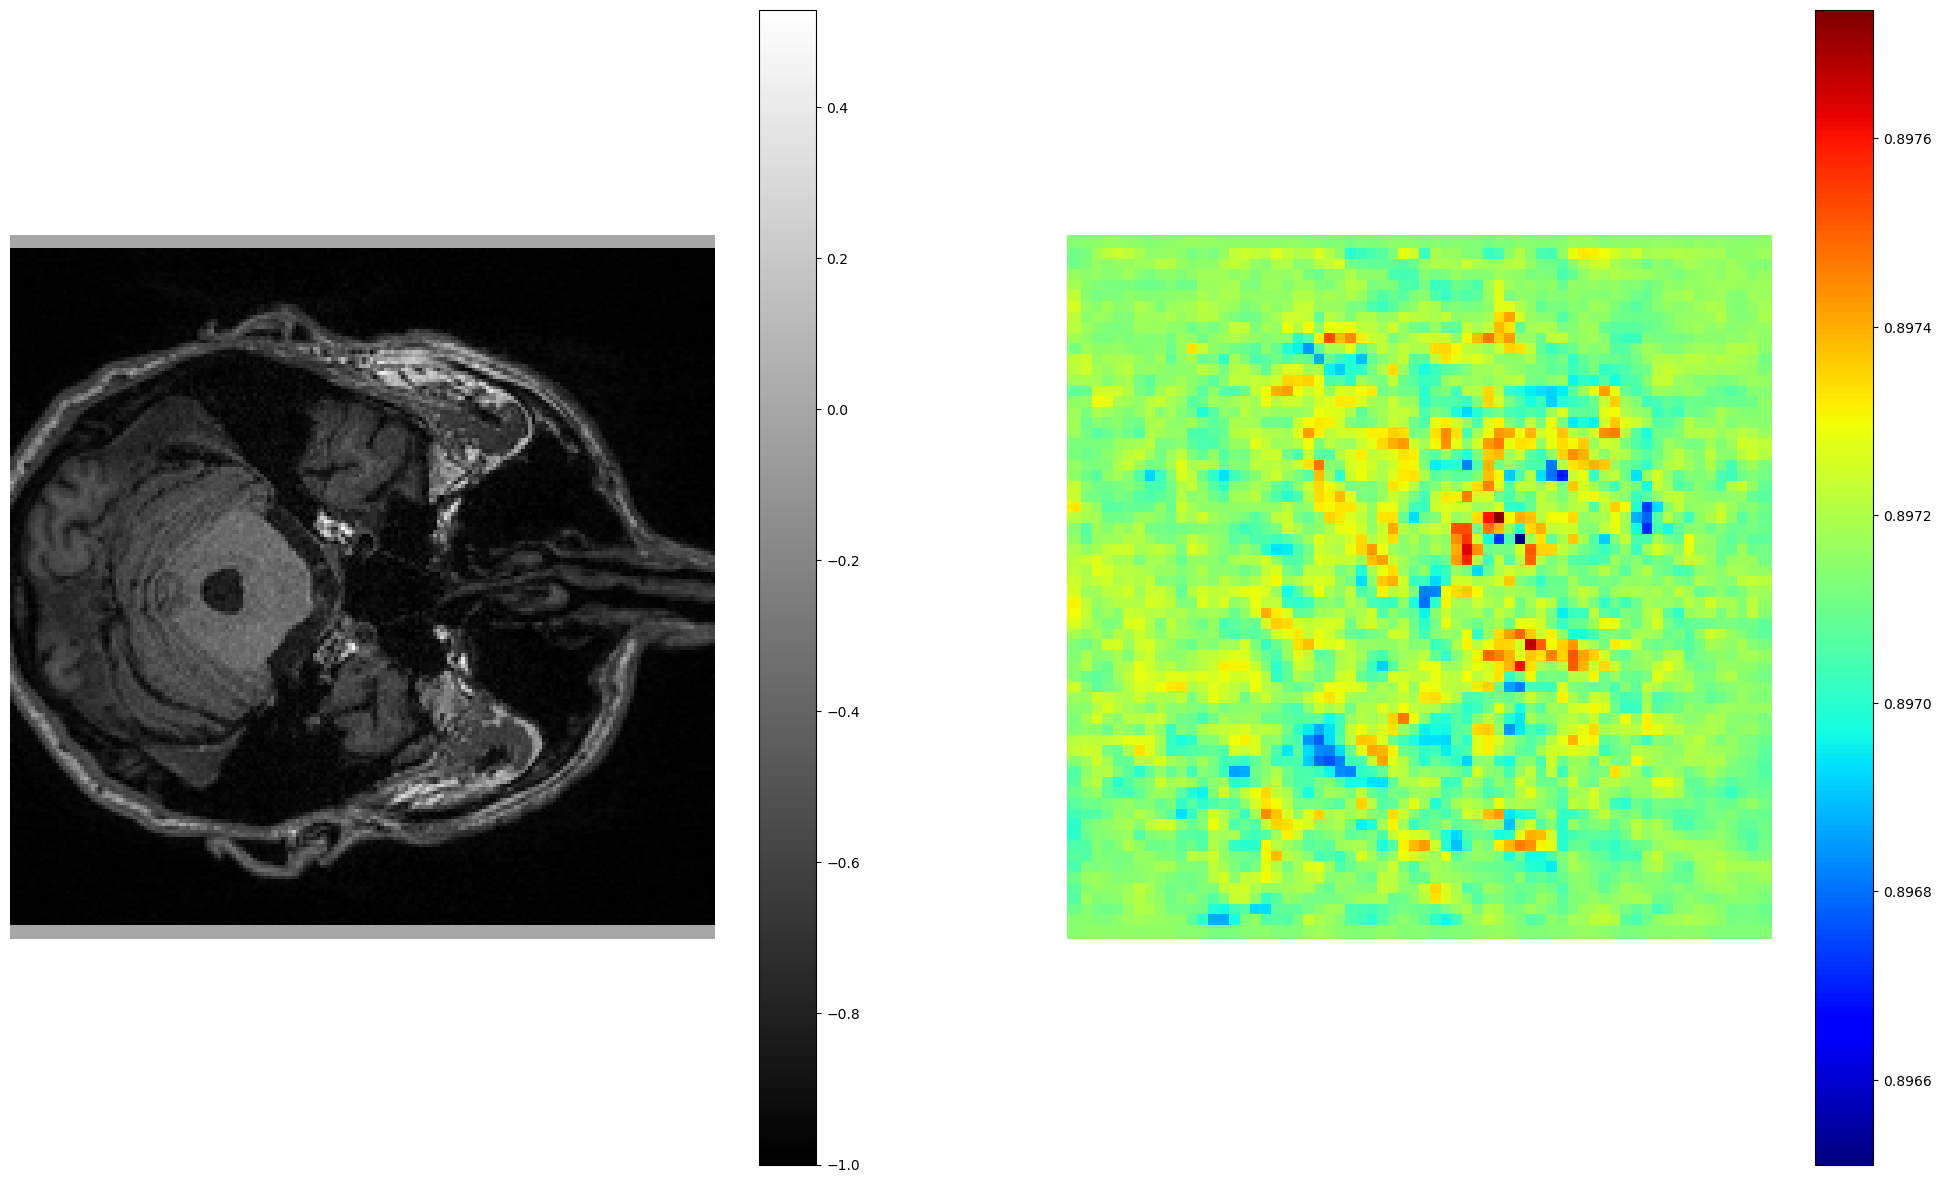

In [76]:
# label 1
occ_result_s = occ_result[0, 1][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([pd_img[..., depth_slice], occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

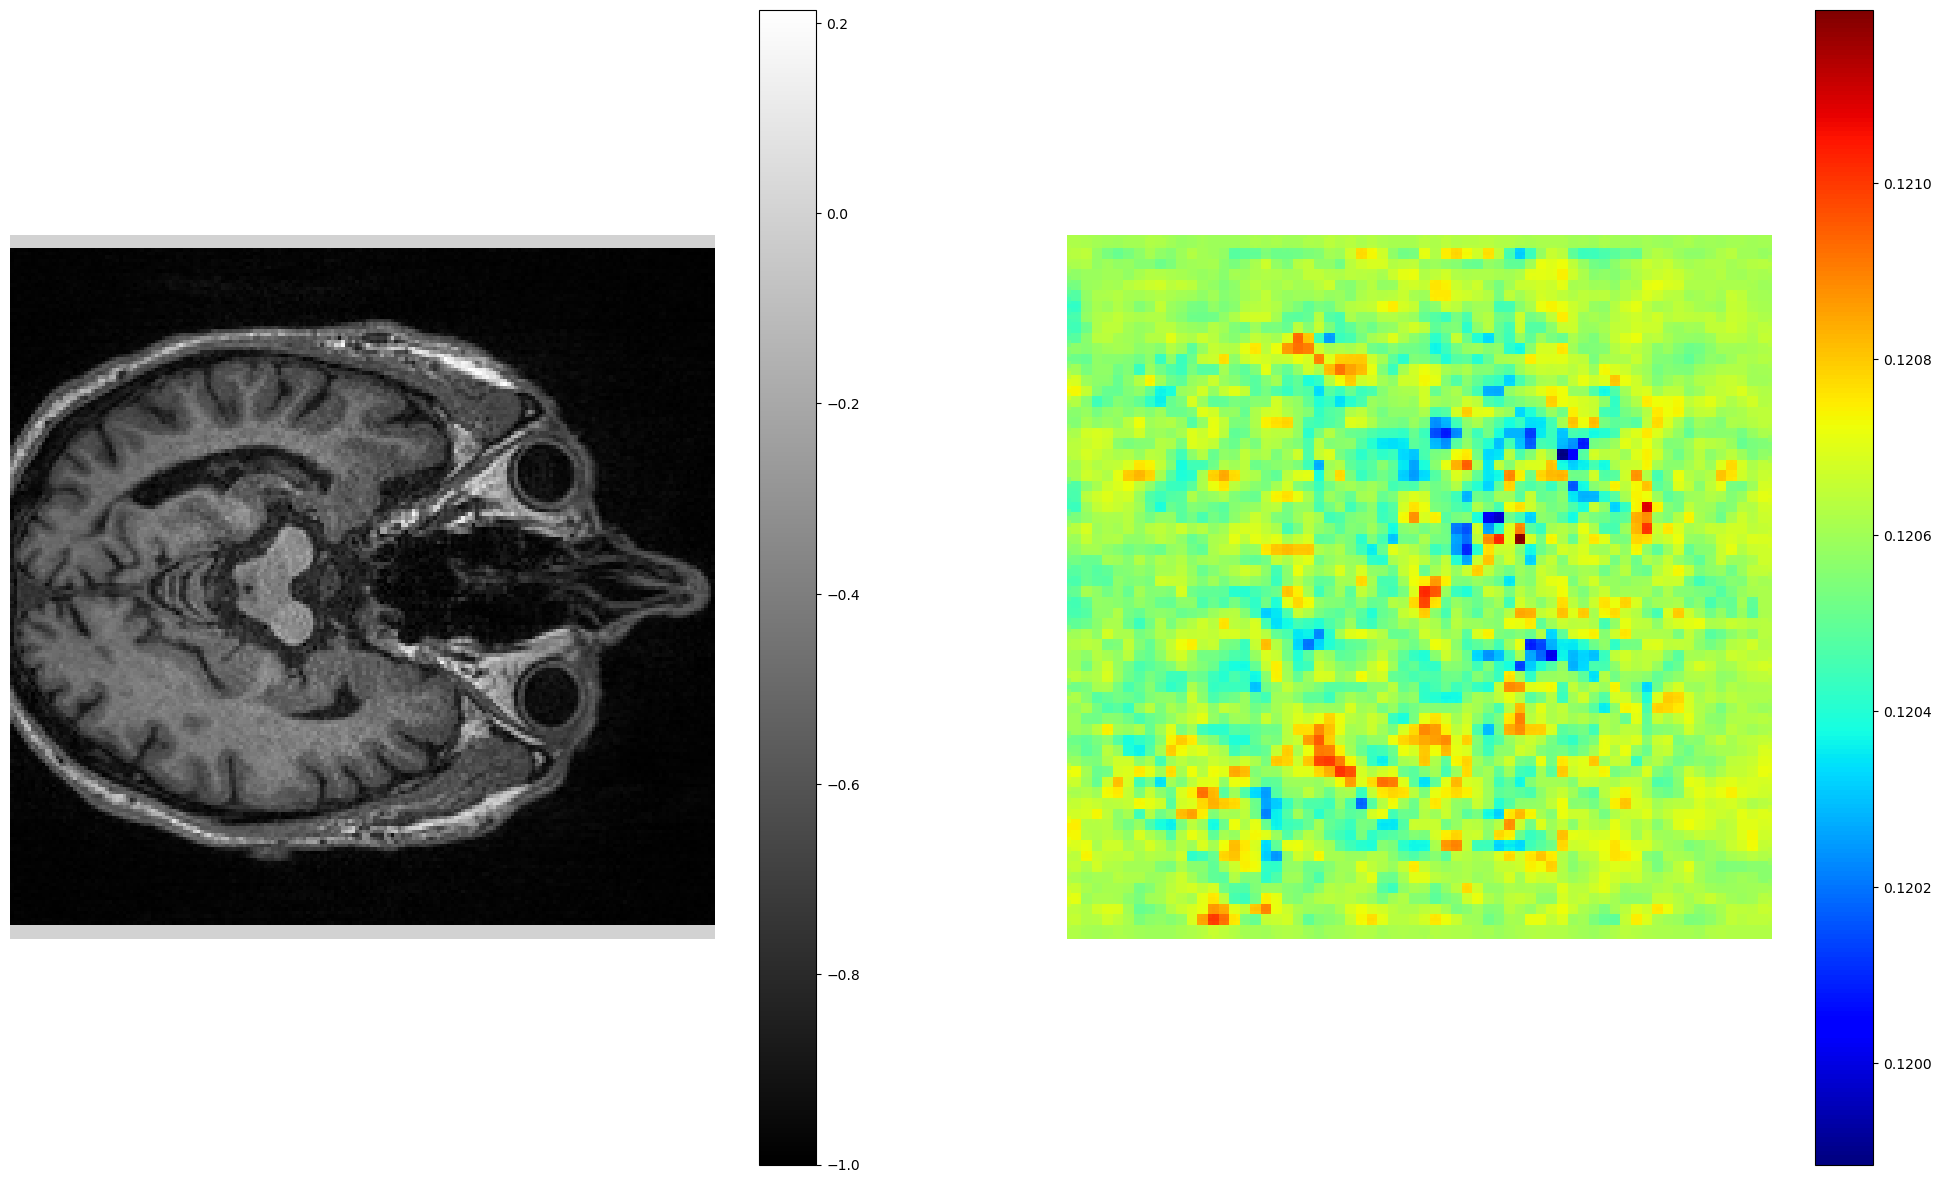

In [61]:
# label 0
occ_result_s = occ_result[0, 0][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([pd_img[..., depth_slice], occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

In [64]:
# hC
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model.net, mask_size=5, n_batch=10, overlap=0.25)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = 85
occ_sens_b_box = [-1, -1, -1, -1, depth_slice - 1, depth_slice]

occ_result_hc, _ = occ_sens(x=hc_img, b_box=occ_sens_b_box)
# occ_result_s = occ_result[0, pd_label.argmax().item()][None]

100%|██████████| 436/436 [05:33<00:00,  1.31it/s]


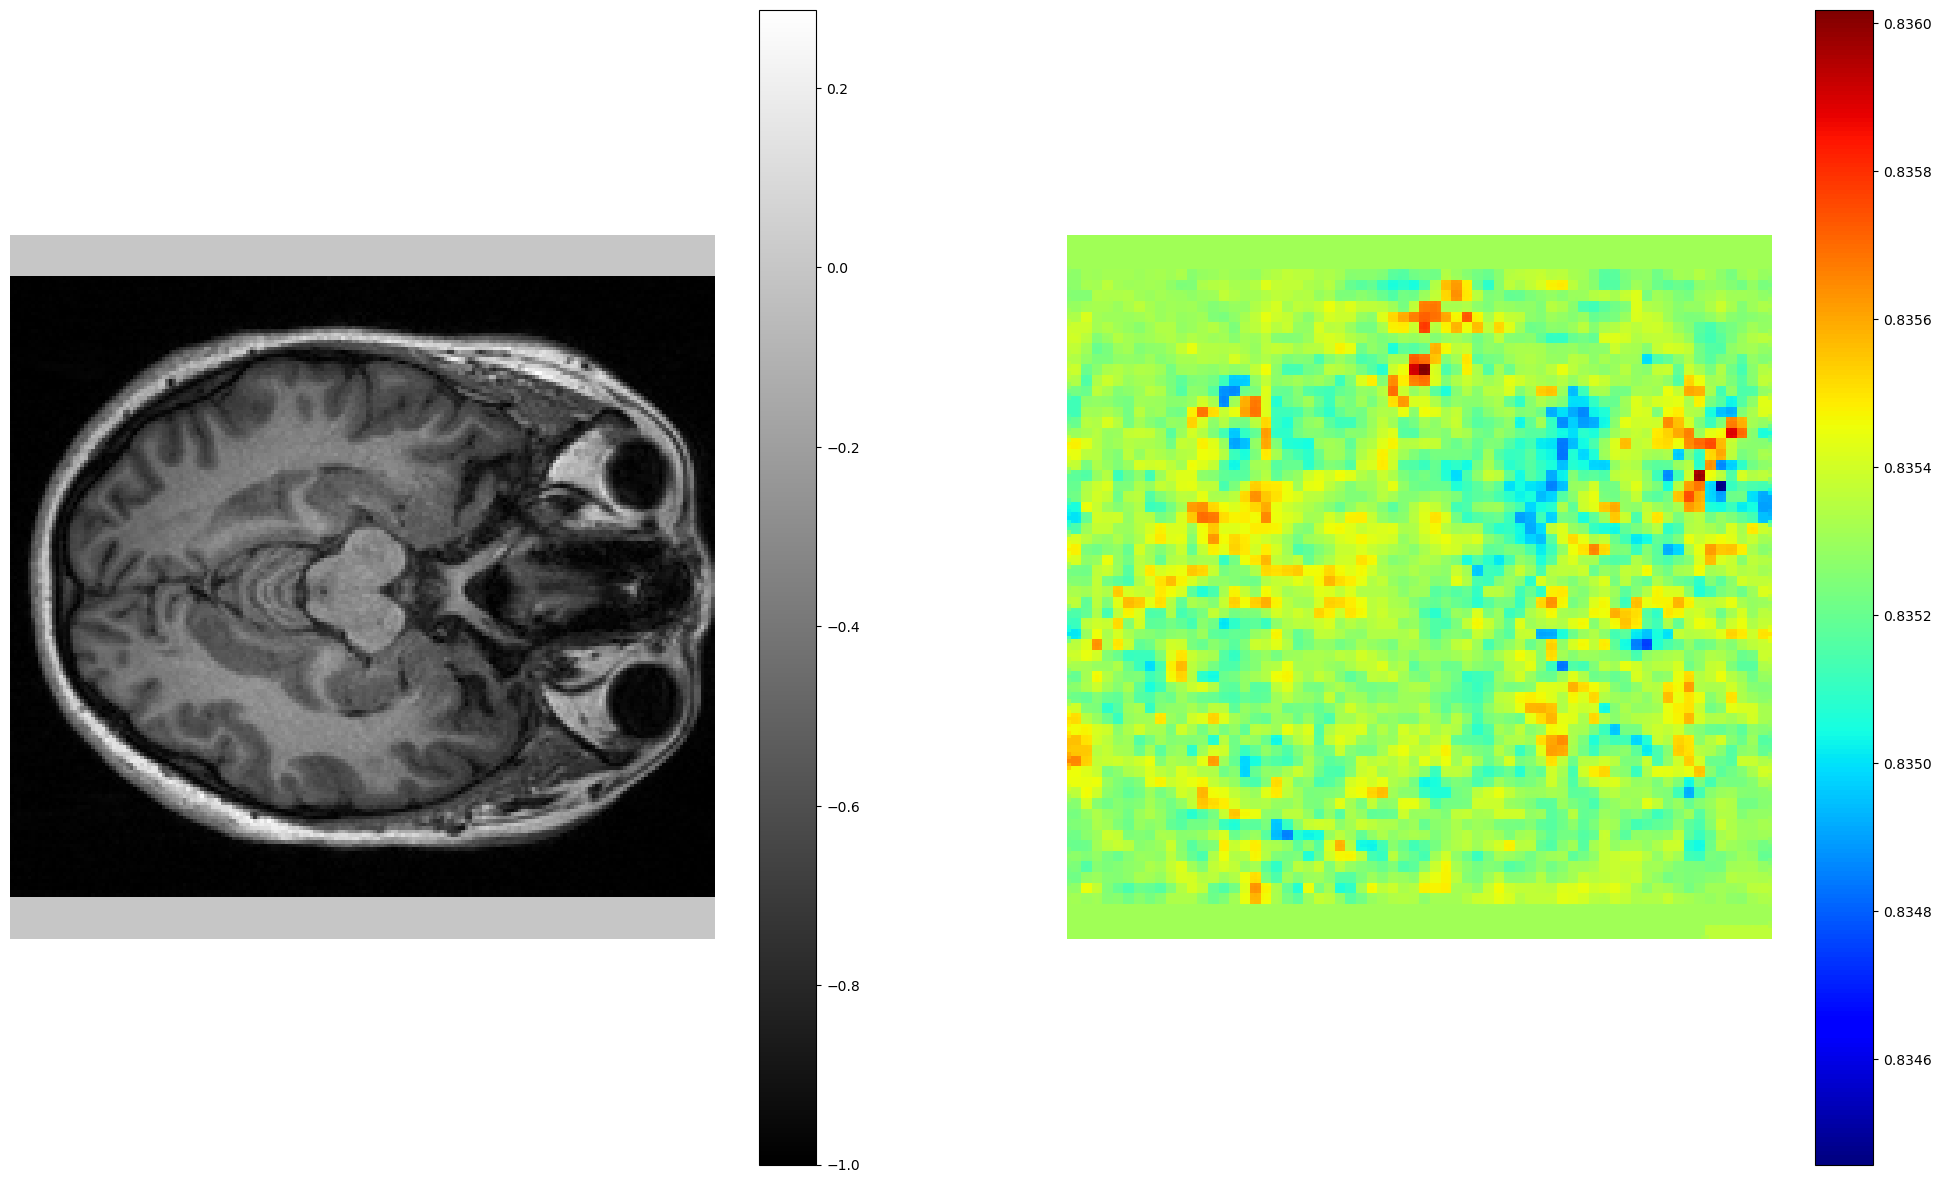

In [68]:
# label 1
occ_result_s = occ_result_hc[0, 1][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([hc_img[..., depth_slice], occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

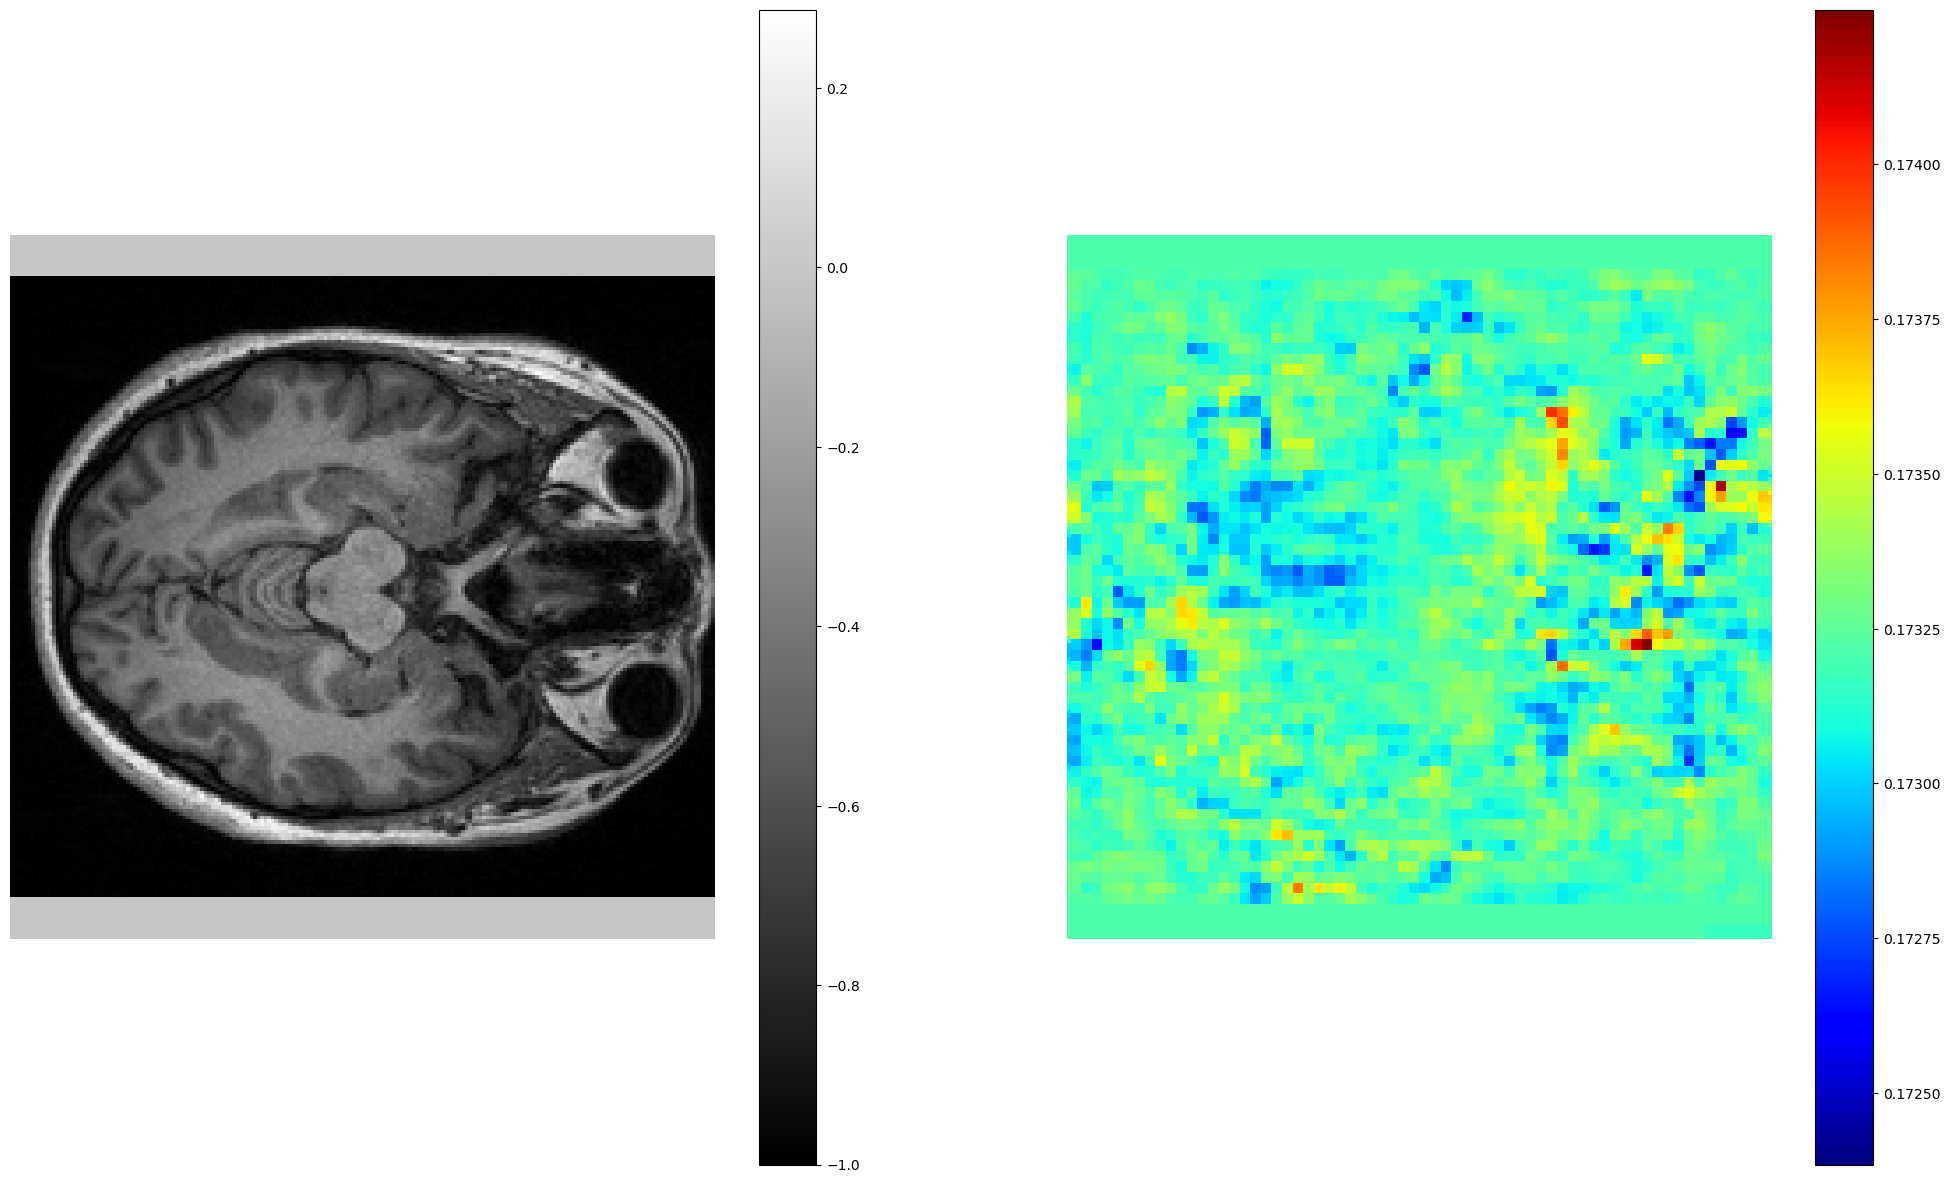

In [69]:
# label 0
occ_result_s = occ_result_hc[0, 0][..., 0]
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([hc_img[..., depth_slice], occ_result_s.unsqueeze(0).unsqueeze(0)]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)